# Rips Complex Tutorial

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import bats
import time

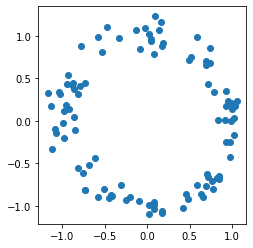

In [2]:
# first, generate a circle
n = 100
X = np.random.normal(size=(n,2))
X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig = plt.scatter(X[:,0], X[:,1])
fig.axes.set_aspect('equal')
plt.savefig('figures/RipsEx_data.png')

Rips filtrations are commonly used in conjunction with persistent homology to create features for finite dimensional metric spaces (point clouds). Given a metric space $(X, d)$, a Rips complex consists of simplices with a maximum pairwise distance between vertices is less than some threshold $r$:

$$
X_r = \{(x_0,\dots,x_k) \mid x_i\in X, d(x_i,x_j) \le r\}.
$$

A Rips filtration is a filtration of Rips complexes $X_r \subseteq X_s$ if $r \le s$.

In [3]:
# compute pairwise distances
D = distance.squareform(distance.pdist(X))

# Rips complex for full metric space
# ie., threshold r = infinity now
F = bats.LightRipsFiltration(bats.Matrix(D), np.inf, 2)

# compute with F2 coefficents
t0 = time.monotonic()
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("time of compute persistent homology: {} sec.".format(t1-t0))

time of compute persistent homology: 0.959796742 sec.


Now you are able to see persistent diagrams.

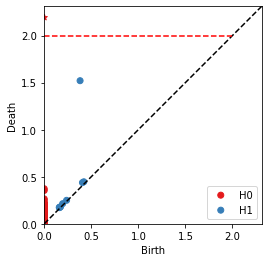

In [4]:
# find persistence pairs at each dimension
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

# Draw persistent diagram
# 'tmax' is the axis maixmum value
fig, ax = bats.persistence_diagram(ps, tmax = 2.0)

## Efficient Computation 
The number of simplices in Rips filtrations quickly grows with the size of the data set, and much effort has gone into developing efficient algorithms for computing persistent homology of Rips filtrations. 

### Construction optimization
The first method that has been applied in several high-performance packages for Rips computations is to stop a filtration at the enclosing ***radius*** of the metric space, at which point the complex becomes contractible, which can reduce the total number of simplices in the filtration considerably without changing persistent homology.

In [5]:
# Two ways to find Enclosing Radius
r_enc = np.min(np.max(D, axis=0))
print("enclosing radius = {}".format(r_enc))

r_enc = bats.enclosing_radius(bats.Matrix(D))
print("enclosing radius = {}".format(r_enc))

enclosing radius = 1.8780346754145678
enclosing radius = 1.8780346754145678


In [6]:
# Rips complex up to enclosing radius
t0 = time.monotonic()
F_enc = bats.LightRipsFiltration(bats.Matrix(D), r_enc, 2)
t1 = time.monotonic()
print("construction time: {} sec.".format(t1-t0))

# compute with F2 coefficents
t0 = time.monotonic()
R_enc = bats.reduce(F_enc, bats.F2())
t1 = time.monotonic()
print("reduction time: {} sec.".format(t1-t0))

construction time: 0.03195132299999992 sec.
reduction time: 0.380939229 sec.


You can see obvious the improvement with about 2x speedup.

### Algorithm optimization

There are also many efficent algorithms provided in BATS.py:
- Reduction
- Compression
- Cohomology
- Update persistence